In [1]:
import pandas as pd
from database import select_dataset
import numpy as np

In [2]:
# FIND WAY TO WRAP THIS CLEANLY CAUSE IT's A MESS !

aquastat = select_dataset('aquastat').dropna()
evapotranspiration = select_dataset('evapotranspiration').dropna().drop_duplicates()
cropcalendar = select_dataset('cropcalendar').drop(columns=['Year'])
efficientwater = select_dataset('efficientwater')
wb_data = select_dataset('worldbank')

In [9]:
def pivot(df):
    return df.pivot(index=['ISO', 'Year'], columns='Variable', values='Value')

def fill_missing_values(df):
    return df.groupby(level='ISO').fillna(method='ffill')\
             .groupby(level='ISO').fillna(method='bfill')

def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code].fillna(0)
    return X

In [4]:
def process_datasets(aquastat, efficientwater, wb_data,  evapotranspiration, cropcalendar):
    '''To cleanup !!! '''
    
    aquastat = aquastat[~aquastat.ISO.isin(['USA', 'CHN', 'IND', 'RUS'])] # Not parsed !
    aquastat = aquastat[aquastat.Variable != 'CI']
    aquastat['Year'] = aquastat['Year'].astype(int)
    wb_data['Year'] = wb_data['Year'].astype(int)
    
    aquastat = fill_missing_values(pivot(aquastat))
    evapotranspiration = pivot(evapotranspiration)
    ETa = fill_missing_values(evapotranspiration['ETa'])
    ETo = evapotranspiration['ETo'].reset_index('Year', drop=True).dropna()
    cropcalendar = cropcalendar.pivot(index=['ISO', 'Item'], columns='Variable', values='Value')
    wb_data = pivot(wb_data)
    efficientwater = pivot(efficientwater)

    X = df_to_dict(aquastat)
    
    gva = df_to_dict(wb_data)
    ew = df_to_dict(efficientwater)
    
    X.update(gva)
    X.update(ew)
    
    X['ETa'] = ETa
    X['ETo'] = ETo
    X['LWU'] = 0
    X['KC'] = cropcalendar['Kc']
    X['ICA'] = cropcalendar['ICA']
    
    X['GDPC'] = X['GDP'] / X['Pop']
    
    return X

In [5]:
data_dict = process_datasets(aquastat, efficientwater, wb_data,  evapotranspiration, cropcalendar)

# Model

In [10]:
from graphmodels.graphmodel_exp import GraphModel, converte_to_format, concatenate_graph_specs
import numpy as np
from graphmodels.validation import check_model, check_variable_graph
from models.Sarah.model_EW import EW_models, MWU_model
from graphmodels.utils import get_X_y_from_data

In [8]:
for model_name, model in EW_models.items():
    print(model_name, ': ')
    X, y = get_X_y_from_data(model, data_dict)
    check_model(model, X, y)

IWW_model : 
Checking computations:
IWR r2: -0.12665142623068482 | IWR corr: 0.9379986749670274
IWW r2: -4.205209733188055 | IWW corr: 0.4184869553410477
AWU r2: -0.0628858927658491 | AWU corr: 0.9135028659380573
EW1_partial_model : 
Checking computations:
TWW r2: 0.9899453815126853 | TWW corr: 0.9949795916522841
EW1 r2: -1.3182233892117088 | EW1 corr: 0.49113714674572345
EW2_partial_model : 
Checking computations:
EW1_model : 


/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Checking computations:
IWR r2: -0.12665142623068482 | IWR corr: 0.9379986749670274
IWW r2: -4.205209733188055 | IWW corr: 0.4184869553410477
AWU r2: -0.0628858927658491 | AWU corr: 0.9135028659380573
MWU r2: 0.6893387462633556 | MWU corr: 0.9253824745744593
TWW r2: 0.19825242635480045 | TWW corr: 0.9091621087829711
EW1 r2: -0.32604077592304637 | EW1 corr: 0.412509754305518
EW2_model : 


/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Checking computations:
IWR r2: -0.12665142623068482 | IWR corr: 0.9379986749670274
IWW r2: -4.205209733188055 | IWW corr: 0.4184869553410477
AWU r2: -0.0628858927658491 | AWU corr: 0.9135028659380573
MWU r2: 0.6893387462633556 | MWU corr: 0.9253824745744593


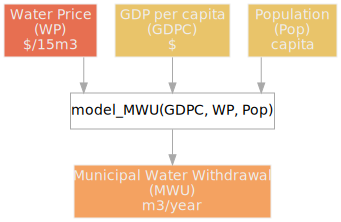

In [11]:
MWU_model.draw()